In [1]:
# Não exibir warnings
import os
import sys
sys.stderr = open(os.devnull, "w")  # silence stderr
sys.stderr = sys.__stderr__  # unsilence stderr

In [2]:
#https://github.com/PacktPublishing/Neural-Network-Projects-with-Python/blob/master/Chapter04/main_vgg16.py

from keras.applications.inception_v3 import InceptionV3
from keras.models import Model

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
#Função de geração da matriz de confusão
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=11):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, cmap="YlGnBu", annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='right', fontsize=fontsize)
    
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return fig  

In [4]:
batch = 32
#num_train = 5600
#num_validation = 2400

In [5]:
### Transfer Learning ###

#inception = InceptionV3(include_top=False, weights='imagenet', input_shape=(128,128,3))

# Data Science with Python: Combine Python with machine learning principles to discover hidden patterns in raw data
#for layer in inception.layers[:5]:
#    layer.trainable = False

# Add a fully connected layer with 2 nodes at the end 
#input_ = inception.input
#output_ = inception(input_)
#last_layer = Flatten(name='flatten')(output_)
#last_layer = Dense(2, activation='sigmoid')(last_layer)
#model = Model(input=input_, output=last_layer)

#https://stackoverflow.com/questions/48890758/pre-training-keras-xception-and-inceptionv3-models
base_model = InceptionV3(include_top=False, pooling='avg',input_shape=(128,128,3))
for layer in base_model.layers:
    layer.trainable = False
output = Dense(2, activation='softmax')(base_model.output)
model = Model(base_model.input, output)



model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [6]:
print ("### Estrutura InceptionV3 ###")
base_model.summary()

print ("\n\n### Estrutura do modelo ###")
model.summary()

### Estrutura InceptionV3 ###
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 63, 63, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 63, 63, 32)   0           batch_normalization_1[0][0]      
_________________________________________________________

In [7]:
# Part 2 - Fitting the CNN to the images

from keras.preprocessing.image import ImageDataGenerator

#Conjunto de treinamento
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory('classificador_B/train',
                                                 target_size = (128, 128),
                                                 color_mode="rgb",
                                                 batch_size = batch,
                                                 class_mode = 'categorical',
                                                 shuffle = True)

print (training_set.class_indices)
#Conjunto de validação
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_set = validation_datagen.flow_from_directory('classificador_B/validation/',
                                            target_size = (128, 128),
                                            color_mode="rgb",
                                            batch_size = batch, #alterado para 1
                                            class_mode = 'categorical',
                                            shuffle=True)
num_train = training_set.samples
num_validation = validation_set.samples

Found 2800 images belonging to 2 classes.
{'docs_gerais': 0, 'docs_identificacao': 1}
Found 1200 images belonging to 2 classes.


In [8]:
with tf.device('/gpu:0'): #rodar na GPU
    history = model.fit_generator(training_set,
                         steps_per_epoch = (num_train//batch),
                         epochs = 50,
                         validation_data = validation_set,
                         validation_steps = (num_validation//batch), verbose=1)
    

model.save('modelo_classificador_B_InceptionV3_novo.h5')


Epoch 1/50
87/87 [==============================] - 100s 1s/step - loss: 0.4604 - accuracy: 0.7915 - val_loss: 0.2528 - val_accuracy: 0.7956
Epoch 2/50
87/87 [==============================] - 71s 811ms/step - loss: 0.2926 - accuracy: 0.8985 - val_loss: 0.2168 - val_accuracy: 0.8853
Epoch 3/50
87/87 [==============================] - 69s 795ms/step - loss: 0.2420 - accuracy: 0.9093 - val_loss: 0.1062 - val_accuracy: 0.9375
Epoch 4/50
87/87 [==============================] - 69s 792ms/step - loss: 0.2297 - accuracy: 0.9205 - val_loss: 0.1492 - val_accuracy: 0.8724
Epoch 5/50
87/87 [==============================] - 72s 828ms/step - loss: 0.2163 - accuracy: 0.9271 - val_loss: 0.2162 - val_accuracy: 0.9144
Epoch 6/50
87/87 [==============================] - 70s 809ms/step - loss: 0.1910 - accuracy: 0.9342 - val_loss: 0.1337 - val_accuracy: 0.9443
Epoch 7/50
87/87 [==============================] - 68s 782ms/step - loss: 0.1858 - accuracy: 0.9368 - val_loss: 0.6438 - val_accuracy: 0.9084


Train accuracy: 0.944
Train loss: 0.166 

Validation accuracy: 0.878
Validation loss: 1.125


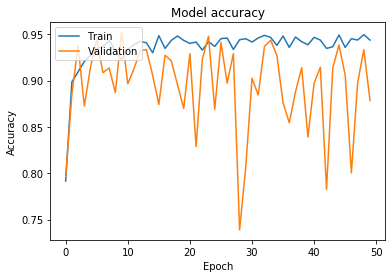

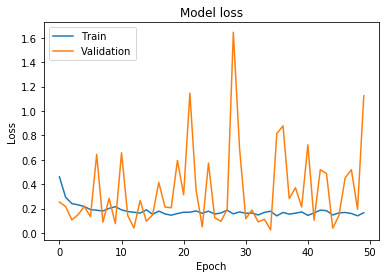

In [9]:
# Final accuracy and loss
print ("Train accuracy: %.3f" % (history.history['accuracy'][-1]))
print ("Train loss: %.3f" % (history.history['loss'][-1]),"\n")

print ("Validation accuracy: %.3f" % (history.history['val_accuracy'][-1]))
print ("Validation loss: %.3f" % (history.history['val_loss'][-1]))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Matriz de confusão para o conjunto de validação ###
Found 1200 images belonging to 2 classes.
37/37 [==============================] - 20s 532ms/step


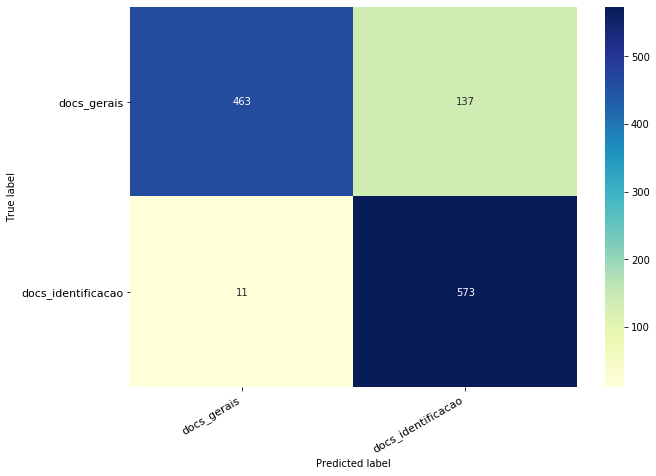

In [10]:
### Conjunto de Validação ###

print ("### Matriz de confusão para o conjunto de validação ###")

#Conjunto de validação
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_set = validation_datagen.flow_from_directory('classificador_B/validation/',
                                            target_size = (128, 128),
                                            color_mode="rgb",
                                            batch_size = batch, #alterado para 1
                                            class_mode = 'categorical',
                                            shuffle= False)


#Confution Matrix
Y_pred = model.predict_generator(validation_set, num_validation//batch, verbose=1)

test_preds = np.argmax(Y_pred, axis=-1)
l=test_preds.shape[0]
test_trues = validation_set.classes
cm =confusion_matrix(test_trues[:l], test_preds)

print_confusion_matrix(cm, ["docs_gerais", "docs_identificacao"], figsize = (10,7), fontsize=11)


### Matriz de confusão para o conjunto de teste ###
Found 600 images belonging to 2 classes.
600/600 [==============================] - 24s 40ms/step
Test accuracy: 0.882
Test loss: 0.000


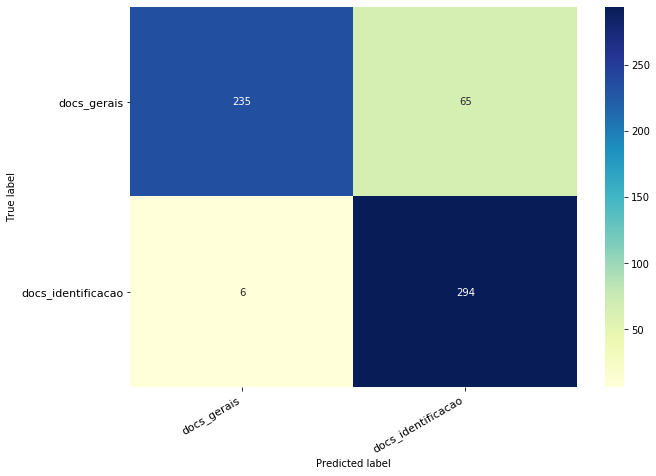

In [12]:
### Conjunto de Teste ###

print ("### Matriz de confusão para o conjunto de teste ###")

test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('classificador_B/test/',
                                            target_size = (128, 128),
                                            color_mode="rgb",
                                            batch_size = 1,
                                            class_mode = 'categorical',
                                            shuffle=False)
num_test = test_set.samples


#Confution Matrix
Y_pred = model.predict_generator(test_set, num_test, verbose=1)

test_preds = np.argmax(Y_pred, axis=-1)
l=test_preds.shape[0]
test_trues = test_set.classes
cm =confusion_matrix(test_trues[:l], test_preds)

print_confusion_matrix(cm, ["docs_gerais", "docs_identificacao"], figsize = (10,7), fontsize=11)

# Accuracy and Loss for the Test set
loss, acc = model.evaluate_generator(test_set, num_test, verbose=1)

# Final accuracy and loss
print ("Test accuracy: %.3f" % acc)
print ("Test loss: %.3f" % loss)
